### 138 project redo/new stuff

In [2]:
import pandas as pd
import abagen
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import ggseg
# plt.rcParams["figure.figsize"] = (10,8)

#### for possible gene reduction

In [34]:
# cell type: 'Astro', 'Endo', 'Micro', 'Neuro-Ex', 'Neuro-In', 'Oligo', 'OPC'
# gda: 3397 AD genes dataset


cell_types = pd.read_csv('data/celltypes-Copy1.csv')
gda = pd.read_csv('data/gda.csv')

### parcellation

In [8]:
# files = abagen.fetch_microarray(donors='all', verbose=0)

# fetch dk parcellation file

atlas = abagen.fetch_desikan_killiany()

In [10]:
csv = pd.read_csv('data/atlas-desikankilliany.csv') # labels
csv.index = csv['id']

In [11]:
left_atlas = csv[:41] # only use left
left_atlas.drop(columns=['id'],axis=1, inplace=True)

In [79]:
ad_regions = [5, 6, 8, 15, 40] # as per neurosynth data and confirmed by lit
left_atlas.loc[ad_regions]

,label,hemisphere,structure
id,,,
5,entorhinal,L,cortex
6,fusiform,L,cortex
8,inferiortemporal,L,cortex
15,parahippocampal,L,cortex
40,hippocampus,L,subcortex/brainstem


In [80]:
# parcellate AD values

from neuromaps.parcellate import Parcellater

parc = Parcellater(atlas['image'], 'mni152')

AD_association = nib.load('data/neurosynth_maps/terms/alzheimer_association-test_z_FDR_0.01.nii')
AD_parc = parc.fit_transform(AD_association, 'mni152')

### Full ABHA

In [ ]:
# ABHA data with atlas parcellation (same as AD_parc), all donors, missing values calculated w/ centroid
expression = abagen.get_expression_data(atlas['image'], missing = 'centroids')

In [18]:
# left only
expression_left = expression[:41]

expression_left['AD'] = AD_parc[0][:41].T

expression_left.drop(expression_left.index[expression_left['AD'] == 0], inplace = True)
expression_left['AD'] = np.log(expression_left['AD'])

In [81]:
expression_left.shape

(22, 15634)

In [82]:
expression_left.nlargest(5,'AD') # 5 highest AD regions

gene_symbol,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,AD
label,,,,,,,,,,,,,,,,,,,,,
5,0.667755,0.543455,0.606849,0.526906,0.423939,0.467107,0.349361,0.716827,0.476033,0.614465,...,0.539385,0.710304,0.358010,0.398148,0.510071,0.713046,0.339948,0.399627,0.574180,0.498512
40,0.490292,0.344296,0.427536,0.586020,0.577370,0.583279,0.291768,0.523781,0.640499,0.234787,...,0.538566,0.719953,0.685794,0.449745,0.564028,0.345236,0.273563,0.583096,0.493267,0.357216
8,0.578291,0.696163,0.420250,0.474752,0.380554,0.363455,0.476270,0.797896,0.383587,0.657303,...,0.570905,0.572326,0.416326,0.471603,0.388065,0.694198,0.616343,0.434626,0.497935,-0.545731
15,0.631017,0.618824,0.373092,0.394127,0.446812,0.397319,0.387885,0.707964,0.473886,0.456811,...,0.641104,0.541905,0.450932,0.439447,0.514867,0.657221,0.446785,0.444901,0.432817,-0.562817
6,0.607915,0.687190,0.406862,0.443856,0.393657,0.396301,0.430365,0.815864,0.378149,0.648211,...,0.623925,0.564380,0.409976,0.484444,0.459454,0.718804,0.572953,0.426043,0.516761,-0.776984


In [83]:
def under_and_over(row):
    under = []
    over = []
    std = expression_left.loc[row][:-1].std()
    mean = expression_left.loc[row][:-1].mean()
    low = mean - 3*std
    high = mean + 3*std
    for key, val in expression_left.loc[5].to_dict().items():
        if val < low:
            under.append(key)
        if val > high:
            over.append(key)
    return under, over

under5 = under_and_over(5)[0]
under40 = under_and_over(40)[0]
under8 = under_and_over(8)[0]
under15 = under_and_over(15)[0]
under6 = under_and_over(6)[0]

under_AD = set(under5 + under40 + under8 + under15 + under6)

over5 = under_and_over(5)[1]
over40 = under_and_over(40)[1]
over8 = under_and_over(8)[1]
over15 = under_and_over(15)[1]
over6 = under_and_over(6)[1]

over_AD = set(over5 + over40 + over8 + over15 + over6)

diff_ex_genes = list(under_AD) + list(over_AD)

In [84]:
# highest gene expression in 5 most AD associated areas

high_ad_regions_genes = {
    'entorhinal' : list(expression_left.loc[5][:-1].nlargest(10).index),
    'hippocampus' : list(expression_left.loc[40][:-1].nlargest(10).index),
    'inferiortemporal' : list(expression_left.loc[8][:-1].nlargest(10).index),
    'parahippocampal' : list(expression_left.loc[15][:-1].nlargest(10).index),
    'fusiform' : list(expression_left.loc[6][:-1].nlargest(10).index)
    
}

In [45]:
x = set(high_ad_regions_genes['entorhinal'] + high_ad_regions_genes['hippocampus'] + high_ad_regions_genes['inferiortemporal'] + 
    high_ad_regions_genes['parahippocampal'] + high_ad_regions_genes['fusiform'])
len(x)

40

In [51]:
full_df_corr = expression_left.corr()

co_gene_dfs = {'APOE': full_df_corr['APOE'].nlargest(11)[1:].to_frame(),
               'APP': full_df_corr['APP'].nlargest(11)[1:].to_frame(),
               'PSEN1': full_df_corr['PSEN1'].nlargest(11)[1:].to_frame(),
               'PSEN2': full_df_corr['PSEN2'].nlargest(11)[1:].to_frame()
              }

In [54]:
# util

def plot_gene_coexp(df):
    
    alpha_scatter = 0.3

    for i in df.index:
        
        plt.scatter(expression[df.keys()[0]], expression[i], alpha=alpha_scatter)

        m1, b1 = np.polyfit(expression[df.keys()[0]], expression[i], 1)

        plt.plot(expression[df.keys()[0]],m1*expression[df.keys()[0]] + b1, label=f'{i}')

    plt.legend(loc=2, title=f'{df.keys()[0]} Correlated Genes')
    plt.show()

# plot_gene_coexp(co_gene_dfs['PSEN2'])

## correlations

#### just AD vs all genes

In [65]:
# keep !!!
# AD_corr = expression[expression.columns].corr()['AD']
AD_corr_left = expression_left[expression_left.columns].corr()['AD']

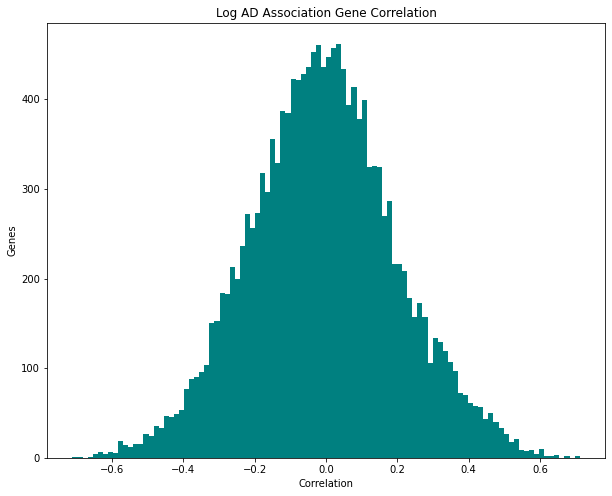

In [66]:
plt.title('Log AD Association Gene Correlation') 
plt.ylabel('Genes')
plt.xlabel('Correlation') 
log_hist_bins = plt.hist(AD_corr_left[:-1],bins=100,color='teal')

In [67]:
# util

def dk_plot_gene(gene):
    # plots gene expression on surface    
    data = {}
    for i in range(34):
        left = f'{csv.loc[i+1].label}_left'
        data[left] = float(abs(expression[gene][i+1]))*10
    for i in range(34,68):
        right = f'{csv.loc[i+1].label}_right'
        data[right] = float(abs(expression[gene][i+1]))*10


    plot = ggseg.plot_dk(data, cmap='Spectral', figsize=(6,6), 
                  background='k', edgecolor='w', bordercolor='gray',
                  ylabel='AD Association Level', 
                  title=f"{gene} Expression")
    return plot

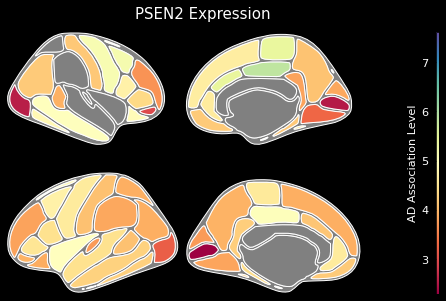

In [68]:
dk_plot_gene('PSEN2')

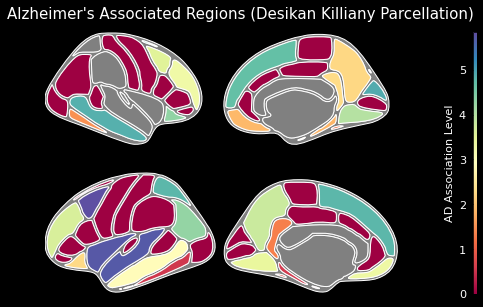

In [69]:
# util

# AD plot


def dk_plot():
    log_AD = [np.log(x) if x != 0 else 0 for x in AD_parc[0]]


    data = {}
    for i in range(34):
        left = f'{csv.loc[i+1].label}_left'
        data[left] = float(abs(log_AD[i]))
    for i in range(34,68):
        right = f'{csv.loc[i+1].label}_right'
        data[right] = float(abs(log_AD[i]))



    plot = ggseg.plot_dk(data, cmap='Spectral', figsize=(6,6),
                  background='k', edgecolor='w', bordercolor='gray',
                  ylabel='AD Association Level', 
                  title="Alzheimer's Associated Regions (Desikan Killiany Parcellation)")
    return plot
dk_plot()

In [70]:
# util

def plot_gene_dk_left(gene):
    plt.figure(figsize=(8, 6))
    plt.ylabel(f'{gene} expression', fontsize=14)
    plt.xlabel('Alzheimer Association Value - Neurosynth', fontsize=14)
    plt.scatter(expression_left['AD'], expression_left[gene])

In [71]:
high_corr_AD_genes = list((AD_corr_left[:-1]).nlargest(50).index)
low_corr_AD_genes = list((AD_corr_left[:-1]).nsmallest(50).index)

In [72]:
# GENES MOST CORRELATED WITH AD ASSOCIATION COLUMN FROM NEUROSYNTH
top_corr_AD_genes = list(abs(AD_corr_left[:-1]).nlargest(50).index)
top_corr_AD_genes[:10]

['ELMO2',
 'GADD45B',
 'LANCL2',
 'RSPO3',
 'TRIM66',
 'DCAF5',
 'NSG1',
 'ARL2',
 'NEURL1B',
 'STXBP6']

In [73]:
# util

def gene_scatter_subplots(df, top_genes):
    """
    Plots left hemi AD association levels vs. gene expression of top 10 genes
    """
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,5))
    ax = ax.flatten()
    
    for i in range(10):
        
        ax[i].scatter(df['AD'], df[top_genes[i]], color='purple')
        ax[i].set_title(f"{top_genes[i]}")
    
    plt.tight_layout()
    plt.xlabel('Log AD Association', fontsize=18)
    plt.show()

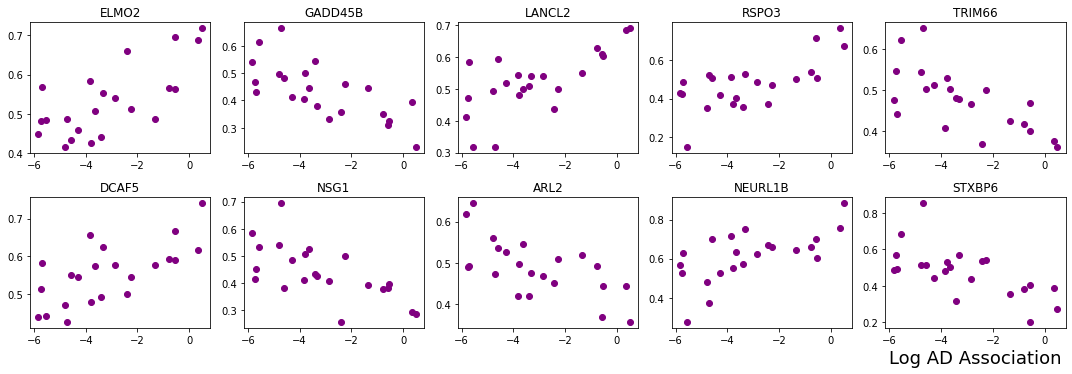

In [74]:
gene_scatter_subplots(expression_left, top_corr_AD_genes)

In [330]:
# expression['AD'] = AD_parc.T

In [331]:
# expression['AD'] = np.log(expression['AD'])

In [332]:
# expression.drop(expression.index[expression['AD'] == 0], inplace = True)

In [75]:
left_coexp = pd.DataFrame({
    'ELMO2': expression_left['ELMO2'],
    'GADD45B': expression_left['GADD45B'],
    'LANCL2': expression_left['LANCL2'],
    'RSPO3': expression_left['RSPO3'],
    'TRIM66': expression_left['TRIM66'],
    'DCAF5': expression_left['DCAF5'],
    'NSG1': expression_left['NSG1'],
    'ARL2': expression_left['ARL2'],
    'NEURL1B': expression_left['NEURL1B'],
    'STXBP6': expression_left['STXBP6']
})

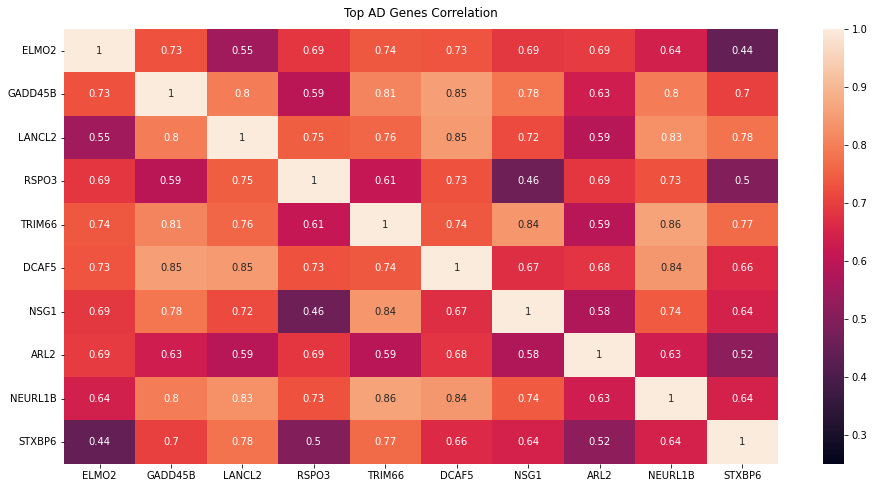

In [76]:
# top genes co-expression heatmap
import seaborn as sns
plt.figure(figsize=(16, 8))
new_heat = sns.heatmap(abs(left_coexp.corr()), annot=True, vmin=0.25, vmax=1);
new_heat.set_title('Top AD Genes Correlation', fontdict={'fontsize':12}, pad=12);

<BarContainer object of 20 artists>

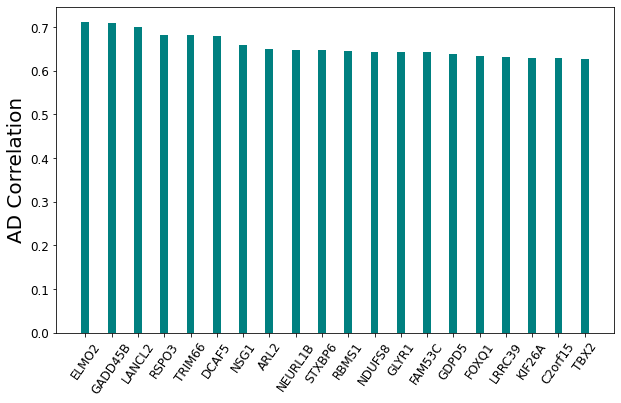

In [77]:
# 10 genes most correlated w/ AD association level
x = abs(AD_corr_left[:-1]).nlargest(20).index
plt.figure(figsize=(10, 6))
plt.ylabel('AD Correlation',fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=55)
plt.bar(x=x,height=abs(AD_corr_left[:-1]).nlargest(20), width=0.3, color='teal')

In [78]:
def get_ahba_AD():
    
    # load AD association map
    AD = nib.load('data/neurosynth_maps/terms/alzheimer_association-test_z_FDR_0.01.nii')
    
    # atlas 
    csv = pd.read_csv('data/atlas-desikankilliany.csv')
    csv.index = csv['id'] ##
    atlas = abagen.fetch_desikan_killiany()
    
    expression = abagen.get_expression_data(atlas['image'], csv, missing='centroids')
    expression_left = expression[:41]
    expression_left['AD'] = AD_parc[0][:41].T
    expression_left.drop(expression_left.index[expression_left['AD'] == 0], inplace = True)
    expression_left['AD'] = np.log(expression_left['AD'])
    
    return expression_left

In [1]:
import warnings
warnings.filterwarnings('ignore')